# Imports

In [398]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from misc_tools import Plotter, Smoother
import warnings
warnings.filterwarnings("ignore")
plt.rcdefaults()

# Defining the Directories

In [399]:
sequence = "ref"
DATA_DIR = '../../data/extracted_images/' + sequence
RESULT_DIR = '../../data/results/' + sequence

# Getting Informations and Reading the Files

## Getting Frame Information

In [400]:
info_dict = {
    "first_frame": 1,
    "last_frame": 2,
    "contact_frame": 3,
    "leave_frame": 4,
    "angle": 5,
    "passthrough": 6,
}

In [401]:
def get_info(file):
    information = {}
    with open(file, "r") as f:
        texts = f.readlines()
    for key, value in info_dict.items():
        line = texts[value]
        info = line.split(":")[1].strip()
        information[key] = info
    return information

information = get_info(f"{DATA_DIR}.txt")

In [402]:
first_frame = DATA_DIR + "/" +information["first_frame"]
last_frame = DATA_DIR + "/" +information["last_frame"]
contact_frame = DATA_DIR + "/" +information["contact_frame"]
angle = information["angle"]
leave_frame = DATA_DIR + "/" +information["leave_frame"]
passthrough = information["passthrough"]

In [403]:
first_frame, last_frame

('../../data/extracted_images/ref/017', '../../data/extracted_images/ref/161')

## Converting the Frame ID to Integer

In [404]:
reg = re.compile(r"\d{3}")
first_frame_num = int(reg.findall(first_frame)[0])
contact_frame_num = int(reg.findall(contact_frame)[0])
leave_frame_num = int(reg.findall(leave_frame)[0])
first_frame_num, contact_frame_num, leave_frame_num

(17, 68, 107)

## Reading the DF

In [405]:
df_name = sequence+"_raw.csv"
df = pd.read_csv(RESULT_DIR + '/'+df_name)
df_c = df[df["x"].notna()]

# Fitting Curves

## The Curves to be Fitted

We'll assume that downward is the positive direction. In this way, the gravitational acceleration is positive. In x direction, no force is acting and hence the equation of motion is simply:
$$
x(t) = x_0 + v_{x0}t
$$
Here $x_0$ is the initial x position, $v_{x0}$ is the initial y velocity.

Now, in y direction, the equation of motion is:
$$
y(t) = y_0 + v_{y0}t + \frac{1}{2}gt^2
$$
Here, $y_0$ is the initial y position, $v_{y0}$ is the initial y velocity, and $g$ is the acceleration due to gravity.

We'll optimize these two equations to get the initial velocity and the initial position for x and y direction.

We can also phrase the same problem by eliminating $t$ from the equation of motions. This way, we'll get $y$ as a function of $x$. Eliminating $t$ from the equation of motion, we get:
$$
y = y_0 + \frac{v_y}{v_x}(x - x_0) + \frac{1}{2}g\frac{(x - x_0)^2}{v_x^2}
$$


Here, we have rewritten $v_{x0}$ as $v_x$ and $v_{y0}$ as $v_y$. 
<!-- Defining $\frac{v_y}{v_x}$ as $m$, which is nothing but $\tan(\theta)$ where $\theta$ is the angle between the y and x velocity, we get:
$$
y = y_0 + m(x - x_0) + \frac{1}{2}g\frac{(x - x_0)^2}{v_x^2}
$$ -->

This is a parabola with the parameters $y_0$, $m$, $g$ and $v_x$ and $v_y$. We can use `scipy` to get these parameters.

In [406]:
def the_parabola(x, x0, y0, vy, vx, g):
    second_term = (vy/vx)*(x-x0)
    third_term = 0.5*g*((x-x0)/vx)**2
    return y0 + second_term + third_term
the_parabola_vector = np.vectorize(the_parabola)

However, it turned out that using the parabola does not give a reasonable result. So, we'll be using the parametric equations.

In [407]:
def parametric_x(t, x0, vx0):
    return x0 + vx0*t
parametric_x_vector = np.vectorize(parametric_x)

def parametric_y(t, y0, vy0, g):
    return y0 + vy0*t+0.5*g*t**2
parametric_y_vector = np.vectorize(parametric_y)

## Region III

### Data For Region III

In [408]:
region_3 = df_c[df_c["Region"] == "III"]

In [409]:
X = region_3["x"].values
Y = region_3["y"].values
t = region_3["time"].values
offset = t[0]
tbar = t-offset

In [410]:
tbar

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],
      dtype=int64)

### Fitting the Curves

In [411]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(the_parabola, X, Y, maxfev=10000)
popty, pcovy = curve_fit(parametric_y, tbar, Y)
poptx, pcovx = curve_fit(parametric_x, tbar, X)

In [412]:
popt

array([ 560.76711658, 1108.66745177, -267.15610127,  135.31664826,
         66.38124268])

As you can see, the parameters calculated by the fitting method is ridiculus, even though it fits the parabola well (See the figure below).

In [413]:
poptx, popty

(array([891.79225032,   4.65838661]),
 array([ 6.52793789e+02, -3.52547757e+00,  7.63319255e-02]))

In [414]:
poptx, popty

(array([891.79225032,   4.65838661]),
 array([ 6.52793789e+02, -3.52547757e+00,  7.63319255e-02]))

These values are reasonable.

### Analyzing the Results

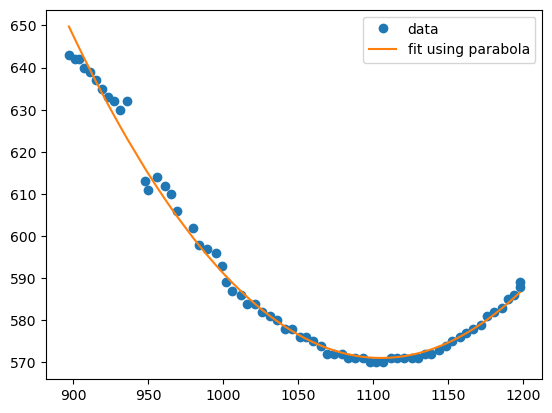

In [415]:
plt.plot(X,Y, 'o', label="data")
plt.plot(X, the_parabola_vector(X, *popt),label="fit using parabola")
plt.legend();

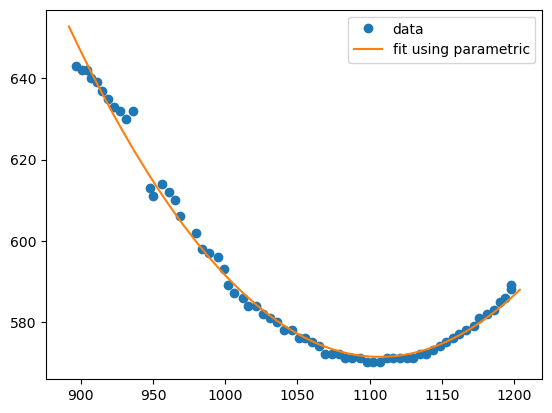

In [416]:
plt.plot(X,Y, 'o', label="data")
plt.plot(parametric_x_vector(tbar, *poptx), parametric_y_vector(tbar, *popty), label="fit using parametric")
plt.legend();

We can see that using the parametric equations, we can fit the curve accurately.

### Getting Speeds

Next, we'll see how the calculated velocities are? The eqaution for the speeds are:
$$
v_x(t) = v_{x0}\\
v_y(t) = v_{y0} + gt
$$

In [444]:
vy = popty[1]+popty[2]*(tbar)
vx = np.ones(len(tbar))*poptx[1]
v = np.sqrt(vy**2+vx**2)

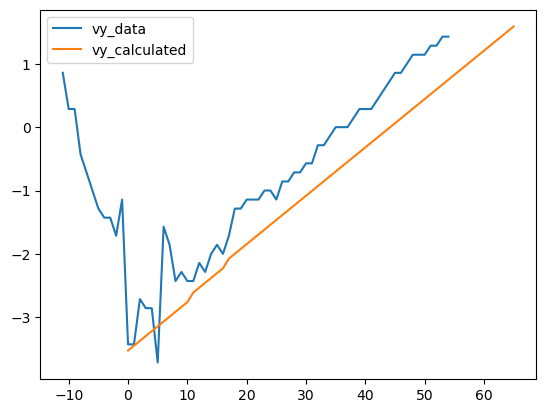

In [418]:
plt.plot(region_3["vy"].index-offset, region_3["vy"].values, label="vy_data")
plt.plot(vy, label="vy_calculated")
plt.legend();

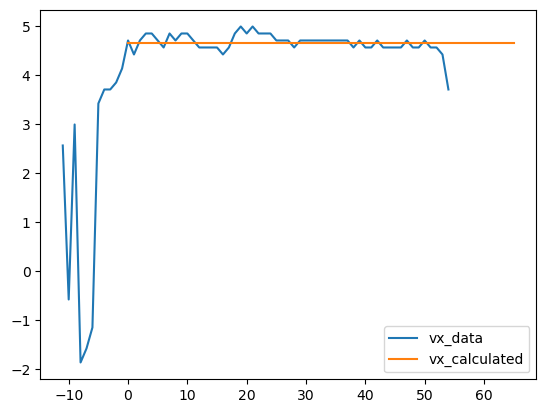

In [419]:
plt.plot(region_3["vx"].index-offset, region_3["vx"].values, label="vx_data")
plt.plot(vx, label="vx_calculated")
plt.legend();

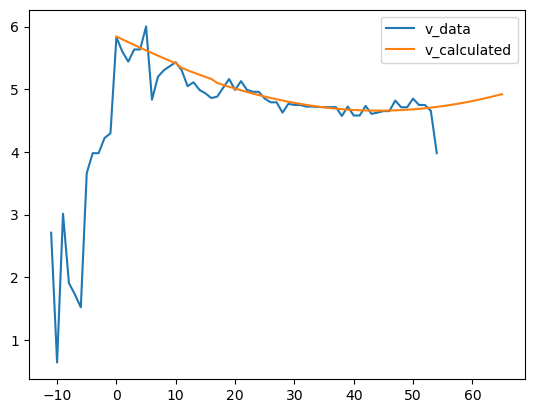

In [445]:
plt.plot(region_3["v"].index-offset, region_3["v"].values, label="v_data")
plt.plot(v, label="v_calculated")
plt.legend();

They are reasonable.

### Getting Angles

Next, let's calculate the angle between the x and y velocity.

In [420]:
angles= np.arctan(vy/vx)*180/np.pi

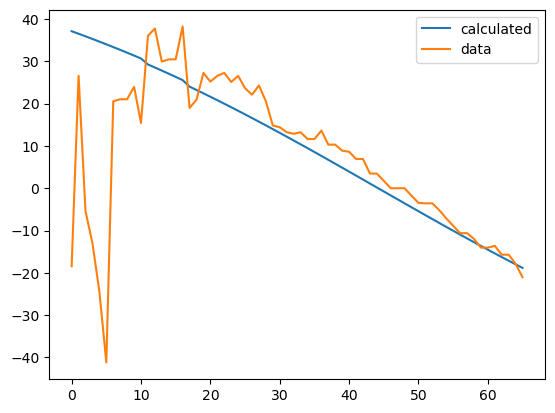

In [421]:
plt.plot(-angles, label = "calculated")
plt.plot(region_3["angle"].values, label = "data")
plt.legend();

Again, reasonable.

## Getting the Additional Information

In [462]:
new_info_df = pd.DataFrame({"vx": vx, "vy": vy, "v":v, "angle": angles, "time":t})
new_info_df.columns = ["vx_using_curve", "vy_using_curve", "v_using_curve", "angle_using_curve", "time"]

In [463]:
new_info_df

,vx_using_curve,vy_using_curve,v_using_curve,angle_using_curve,time
0,4.658387,-3.525478,5.842051,-37.118519,91
1,4.658387,-3.449146,5.796307,-36.516853,92
2,4.658387,-3.372814,5.751212,-35.905683,93
3,4.658387,-3.296482,5.706782,-35.284925,94
4,4.658387,-3.220150,5.663032,-34.654501,95
...,...,...,...,...,...
61,4.658387,1.283434,4.831953,15.403433,154
62,4.658387,1.359766,4.852786,16.272328,155
63,4.658387,1.436098,4.874725,17.133598,156
64,4.658387,1.512430,4.897755,17.986960,157


In [464]:
df_final = pd.merge(df_c, new_info_df, on="time", how="left")
df_final.tail().T

,141,142,143,144,145
id,../../data/extracted_images/ref/154.jpg,../../data/extracted_images/ref/155.jpg,../../data/extracted_images/ref/156.jpg,../../data/extracted_images/ref/157.jpg,../../data/extracted_images/ref/158.jpg
x,1186.0,1190.0,1194.0,1198.0,1198.0
y,583.0,585.0,586.0,588.0,589.0
r1,9.0,9.0,9.0,9.0,5.0
r2,11.0,11.0,11.0,10.0,8.0
theta,119.748179,122.612968,110.580854,26.356059,9.740283
vx,4.714286,4.571429,4.571429,4.428571,3.714286
vy,1.142857,1.285714,1.285714,1.428571,1.428571
v,4.850836,4.748791,4.748791,4.653285,3.97954
angle,-13.626995,-15.708638,-15.708638,-17.878697,-21.037511


## Adding the Additional Information

In [465]:
x_speed = vx[0]
y_speed = vy[0]
speed = v[0]
angle = angles[0]
x_speed, y_speed, speed, angle

(4.6583866068438775,
 -3.5254775721888096,
 5.842050829189072,
 -37.118518888052165)

In [499]:
pattern = "***"
information = f"""USING CURVE FIT AT LEAVE FRAME
### ANGLE: {np.round(angle, 2)}
### VELOCITY: {np.round(speed, 2)}
### X VELOCITY: {np.round(x_speed, 2)}
### Y VELOCITY: {np.round(y_speed, 2)}
{pattern*20}
"""
print(information)

USING CURVE FIT AT LEAVE FRAME
### ANGLE: -37.12
### VELOCITY: 5.84
### X VELOCITY: 4.66
### Y VELOCITY: -3.53
************************************************************



First, create a new string containing just the previous text file. Else we'll duplicate the text file.

In [500]:
with open(RESULT_DIR +"/info.txt", "r+") as f:
    texts = f.readlines()
if len(texts)>44:
    text = "".join(texts[:-6])
else:
    text = "".join(texts)
print(text[:125])
all_text = text+information

### ref.tif
### First Frame ID: 017
### Last Frame ID: 161
### Contact Frame ID: 068
### Leave Frame ID: 090
### Angle: 24.5



In [501]:
len(texts)

49

In [502]:
with open(RESULT_DIR +"/info.txt", "w") as f:
    f.writelines(all_text)

### Save the DataFrame

In [492]:
df_final.to_csv(RESULT_DIR + f"/{sequence}_final.csv", index=False)